<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.

Wir simulieren die Freiheitsgrade eines Armes, der sich im Schultergelenk und im Ellenbogengelenk drehen kann.





<img src='https://github.com/dnhshl/cc-ai/blob/main/images/robot.PNG?raw=1' width="500">




Die kartesischen Koordinaten $(x,y)$ berechnen sich aus den Winkeln $q_1, q_2$ der Roboterarme wie folgt (bitte einmal selbst nachvollziehen!)

$$
x = l_1 \cos(q_1) + l_2 \cos(q_1 + q_2)\\
$$
$$
y = l_1 \sin(q_1) + l_2 \sin(q_1 + q_2)
$$

Die Berechnung der Endposition des Roboterarms bei bekannten Winkeln nennt man **Vorwärtskinematik**. Das ist einfach.

Komplizierter, aber in der Anwendung natürlich wichtiger, ist die **Rückwärtskinematik**. Welche Winkel muss ich einstellen, um eine bestimmte vorgegebene Position erreichen zu können. Für eine geschlossene Lösung müsste man die obigen Gleichungen nach $q_1$ und $q_2$ auflösen. Das ist nicht ganz einfach möglich.

Wir wollen daher ein neuronales Netz trainieren, das diese Aufgabe für uns löst. Also

  * Input $(x,y)$
  * Output $(q_1, q_2)$.

Das ist ein Regressionsproblem.

## Lade notwendige Libraries


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy


# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `q1` und `q2` die `x` und `y` Position berechnet werden kann. 

Der Oberarm kann im Schultergelenk ca. um einen Winkel `q1` zwischen -110 .. 20 Grad  und `q2` im Ellenbogengelenk zwischen 0 .. 90 Grad bewegt werden. Der Einfachheit halber nehmen wir weiterhin an, dass die Oberarmlänge `l1 = 30 cm` und die Unterarmlänge `l2 = 30 cm` sind.

## Hilfsfunktion zur Berechnung der Vorwärts-Kinematik

In [13]:
# Berechne die Vorwärtskinematik. 
# Input ist ein (m,2) Tensor mit den Winkeln
# Output ist ein (m,2) Tensor mit den karthesischen Koordinaten

def forward_kinematics(q):

  x = l1*torch.cos(q[:,0]) +l2*torch.cos(torch.sum(q,1))
  y = l1*torch.sin(q[:,0]) +l2*torch.sin(torch.sum(q,1))
  return torch.stack((x, y), axis=1)


## OK, jetzt also die Trainingsdaten

Wir generieren zufällige Trainingsdaten. 
Eine alternative Möglichkeit wäre, im (q1, q2) Koordinatensystem gleichmäßig zu samplen. Die Verteilung im karthesischen Koordinatensystem wäre dann aber nicht gleichmäßig.

In [88]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

n = 20000 # Wie viele Traingsdaten sollen generiert werden?


def gen_data(size):

  # q1 im Bereich von -110 .. 20 Grad 
  q1 = (torch.rand(size) * 130 - 110) / 180 * torch.pi

  # q2 im Bereich von 0 .. 90 Grad 
  q2 = (torch.rand(size) * 90) / 180 * torch.pi

  # Kombiniere Vektoren als Matrix
  y = torch.stack([q1,q2]).T

  # Berechne x und y
  x = forward_kinematics(y)

  return(x, y)


(x, y) = gen_data(n)

# Da einige Datenpunkte entfernt wurden: Wieviele Trainingsdaten haben wir?


# Wir geben ein paar der Trainingsdaten aus

somedata = np.random.choice(y.shape[0], 5)

print(x[somedata])
print(y[somedata]*180/np.pi)





tensor([[ 0.4800, -0.3012],
        [-0.0844, -0.5867],
        [ 0.2956,  0.3382],
        [ 0.5772, -0.1444],
        [ 0.5608,  0.0316]])
tensor([[ -51.2945,   38.3703],
        [-107.1356,   17.9032],
        [   7.3117,   83.0646],
        [ -21.4688,   14.8423],
        [ -17.3510,   41.1600]])


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

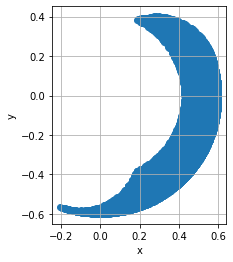

In [21]:

def plot_range():
  plt.figure(1)
  plt.scatter(x[:,0], x[:,1])
  plt.xlabel('x')
  plt.ylabel('y')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/).

Testen Sie auch alternative Anzahlen von Layern und Layergrößen.

## Netzwerkmodell

In [89]:
import torch.nn as nn

# Define the model
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 20),
    nn.Tanh(),
    nn.Linear(20, 2)
)


In [90]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [91]:
import tqdm
from sklearn.model_selection import train_test_split

# train-validation split of the dataset
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, shuffle=True)


In [92]:
# training parameters
n_epochs = 50   # number of epochs to run
batch_size = 256  # size of each batch
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_valid)
    mse = loss_fn(y_pred, y_valid)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch 49: 100%|██████████| 55/55 [00:00<00:00, 171.70batch/s, mse=0.00114]


<All keys matched successfully>

In [93]:
history

[0.10898158699274063,
 0.08205578476190567,
 0.04460623115301132,
 0.017265725880861282,
 0.013023147359490395,
 0.012508509680628777,
 0.011110389605164528,
 0.009329618886113167,
 0.008022681809961796,
 0.006945079658180475,
 0.006004554685205221,
 0.005193344783037901,
 0.004544059280306101,
 0.004050049930810928,
 0.003673823084682226,
 0.0033765246625989676,
 0.003134499303996563,
 0.002936237957328558,
 0.0027744292747229338,
 0.0026429893914610147,
 0.002536737360060215,
 0.002451057778671384,
 0.002381992759183049,
 0.002325797686353326,
 0.0022789561189711094,
 0.0022386035416275263,
 0.0022030395921319723,
 0.0021715727634727955,
 0.0021442659199237823,
 0.0021212082356214523,
 0.0021023559384047985,
 0.002087137894704938,
 0.0020746595691889524,
 0.002063826657831669,
 0.0020535746589303017,
 0.002043144777417183,
 0.0020320024341344833,
 0.0020199778955429792,
 0.0020070946775376797,
 0.0019934894517064095,
 0.0019795200787484646,
 0.001965207513421774,
 0.00195049645844846

MSE: 0.00
RMSE: 0.04


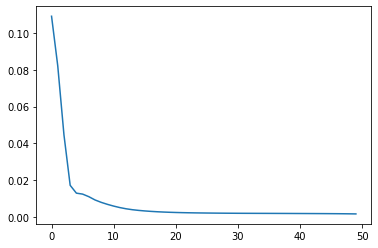

In [94]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

## Trainingsparameter

In [95]:
testdatasize = 1000

(x_test, y_test) = gen_data(testdatasize)



y_pred = model(x_test)

somedata = np.random.choice(y_pred.shape[0], 5)

for d in somedata:
  print(y_pred[d]*180/np.pi, y_test[d]*180/np.pi)

print(forward_kinematics(y_test[somedata]))

print(forward_kinematics(y_pred[somedata]))

mse = loss_fn(y_pred, y_test)
print(mse)

tensor([-43.5870,  70.5919], grad_fn=<DivBackward0>) tensor([-42.3019,  68.7561])
tensor([-84.1754,  23.4371], grad_fn=<DivBackward0>) tensor([-83.6139,  24.8841])
tensor([14.7946, 55.4964], grad_fn=<DivBackward0>) tensor([14.7751, 55.0450])
tensor([-47.7174,  18.8241], grad_fn=<DivBackward0>) tensor([-46.8262,  19.4290])
tensor([-54.5681,  80.2643], grad_fn=<DivBackward0>) tensor([-53.5582,  79.2944])
tensor([[ 0.4905, -0.0683],
        [ 0.1891, -0.5546],
        [ 0.3936,  0.3581],
        [ 0.4716, -0.3568],
        [ 0.4484, -0.1111]])
tensor([[ 0.4846, -0.0706],
        [ 0.1771, -0.5602],
        [ 0.3912,  0.3590],
        [ 0.4645, -0.3669],
        [ 0.4443, -0.1144]], grad_fn=<StackBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)


## Teste verschiedene Trajektorien

### Hilfsfunktionen

In [96]:
# Gerade

def gerade(x1, y1, x2, y2):
  t = np.linspace(0,1)
  x = x1 + t*(x2-x1)
  y = y1 + t*(y2-y1)

  return (x, y)


def kreis(x0, y0, R):
  t = np.linspace(0, 2*np.pi)
  x = x0 + R*np.sin(t)
  y = y0 + R*np.cos(t)

  return (x,y)

def parabelbogen(x1,y1,x2,y2):
  t = np.linspace(0,1)
  x = x1 + (x2-x1) * t
  y = y1 + (y2-y1) * t*t 

  return (x,y)

def plot_trajectory(t, figure=100, zoom=True):
  (x, y) = t
  plt.figure(figure)
  plt.plot(x,y, label='soll')
  X = torch.stack((torch.from_numpy(x), torch.from_numpy(y)), axis=1).float()
  phipred = model(X)

  pred = forward_kinematics(phipred).detach().numpy()

  plt.plot(pred[:,0], pred[:,1], label='ist')
  plt.grid(True)
  plt.legend()
  plt.gca().set_aspect("equal")
  dx = np.max(x) - np.min(x)
  dy = np.max(y) - np.min(y)
  if zoom:
    plt.xlim(np.min(x)-0.1*dx, np.max(x)+0.1*dx)
    plt.ylim(np.min(y)-0.1*dy, np.max(y)+0.1*dy)
  else: 
    plt.xlim(-0.2, 0.6)
    plt.ylim(-0.6, 0.4) 





### Plot

<ipython-input-96-04d9bdc98465>:42: UserWarning: Attempting to set identical bottom == top == -0.2 results in singular transformations; automatically expanding.
  plt.ylim(np.min(y)-0.1*dy, np.max(y)+0.1*dy)


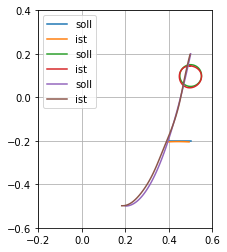

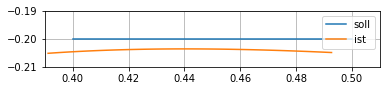

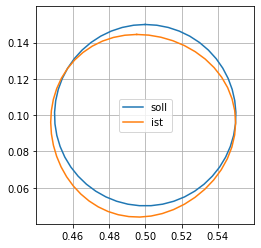

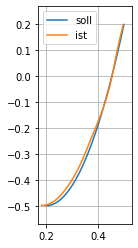

In [97]:
# Alle in einen Plot
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), zoom=False)
plot_trajectory(kreis(0.5, 0.1, 0.05), zoom=False)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), zoom=False)


# Einzelplots gezoomt
plot_trajectory(gerade(0.4,-0.2, 0.5, -0.2), figure=2)
plot_trajectory(kreis(0.5, 0.1, 0.05), figure=3)
plot_trajectory(parabelbogen(0.2,-0.5, 0.5, 0.2), figure=4)
